# Importing Libraries 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.optim as optim
import torch.nn as nn
import time
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import seaborn as sns
import pandas as pd
from torchvision import transforms
device = torch.device("cpu")
# Reffered from pytorch cnn tutorial link: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html The code is modified to suit the requirements of the assignment
print(device)


cpu


# Creating custom data class and importing data 

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_indices = [i for i, label in enumerate(trainset.targets) if label in [0, 1, 2]]
train_labels = [trainset.targets[i] for i in train_indices]
train_idx, val_idx = train_test_split(train_indices, test_size=0.2, stratify=train_labels, random_state=42)
test_indices = [i for i, label in enumerate(testset.targets) if label in [0, 1, 2]]
class dset(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        return self.dataset[real_idx]
batch_size = 5
train_dataset = dset(trainset, train_idx)
val_dataset = dset(trainset, val_idx)
test_dataset = dset(testset, test_indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird')
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")


100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train Dataset Size: 12000
Val Dataset Size: 3000
Test Dataset Size: 3000


# Showing the images of both train and val set 

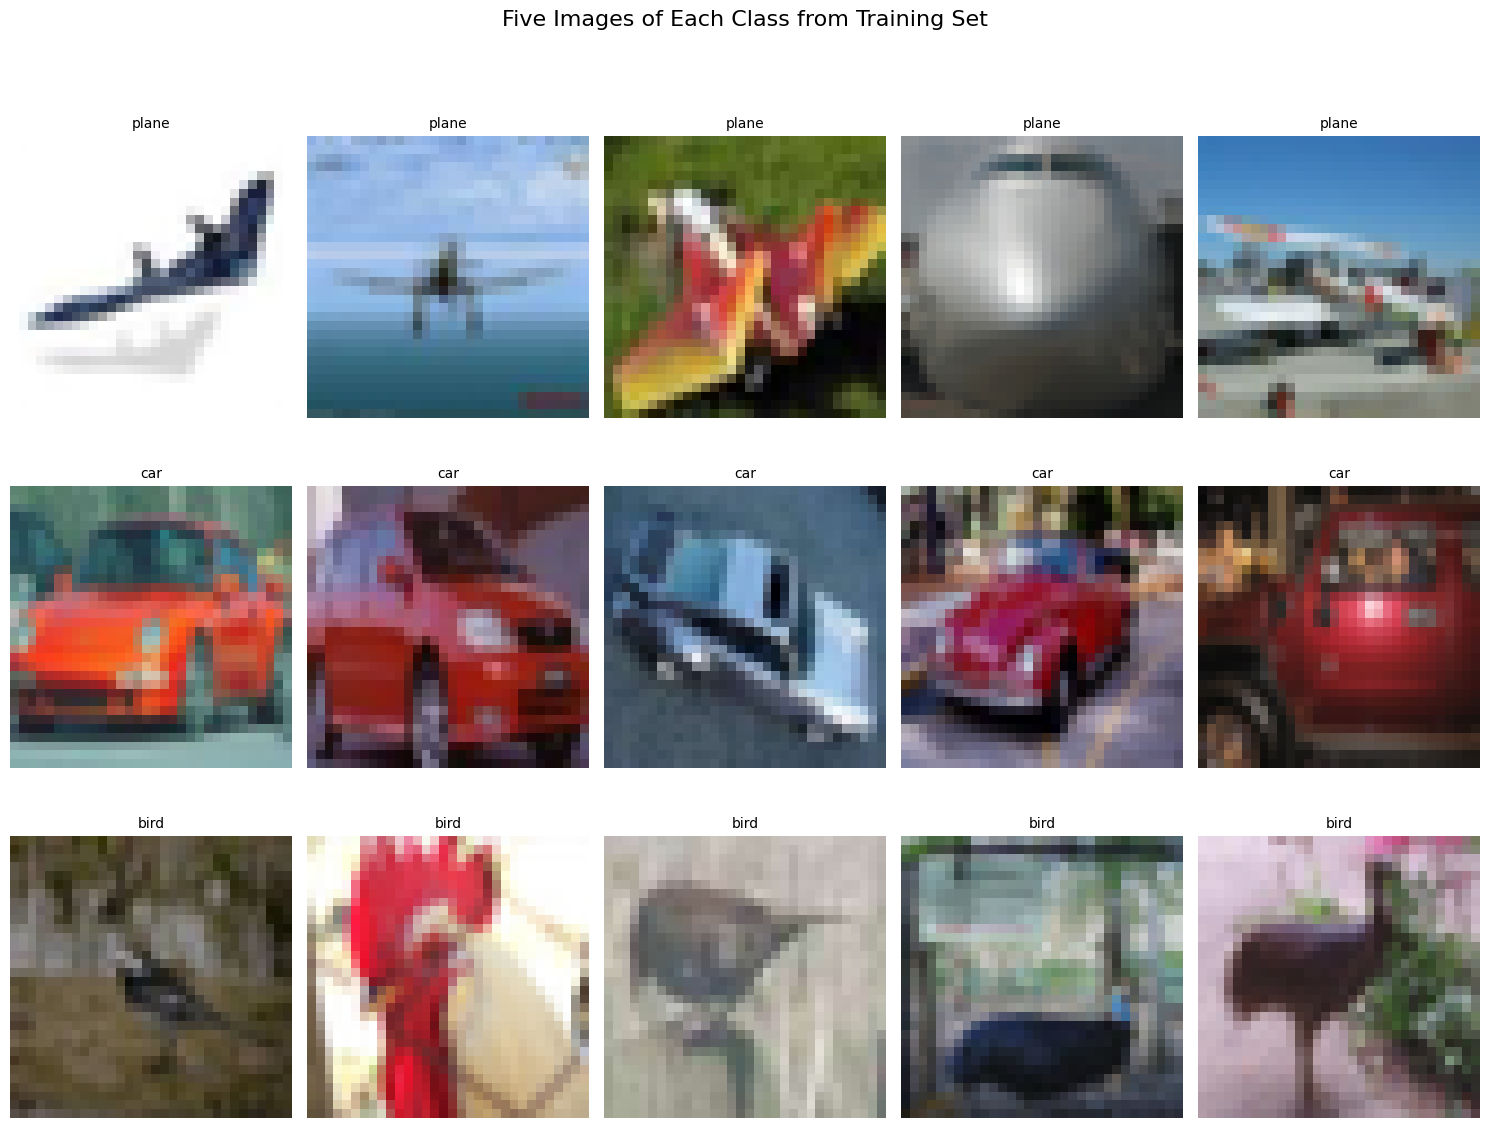

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

class_samples = {i: [] for i in range(len(classes))}

for it in train_loader:
    images, labels = it
    for i in range(len(labels)):
        label = labels[i].item()
        if len(class_samples[label]) < 5:
            class_samples[label].append(images[i])
    if all(len(class_samples[i]) >= 5 for i in range(len(classes))):
        break
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 12))
fig.suptitle('images of plane , car , bird from train set', fontsize=24)
for class_idx, class_name in enumerate(classes):
    for img_idx in range(5):
        ax = axes[class_idx, img_idx]
        img = class_samples[class_idx][img_idx]
        img = img / 2 + 0.5
        npi = img.numpy()
        ax.imshow(np.transpose(npi, (1, 2, 0)))
        ax.axis('off')
        if img_idx == 0:
            ax.set_ylabel(class_name, rotation=0, labelpad=50, fontsize=12, ha='right')
        ax.set_title(class_name, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

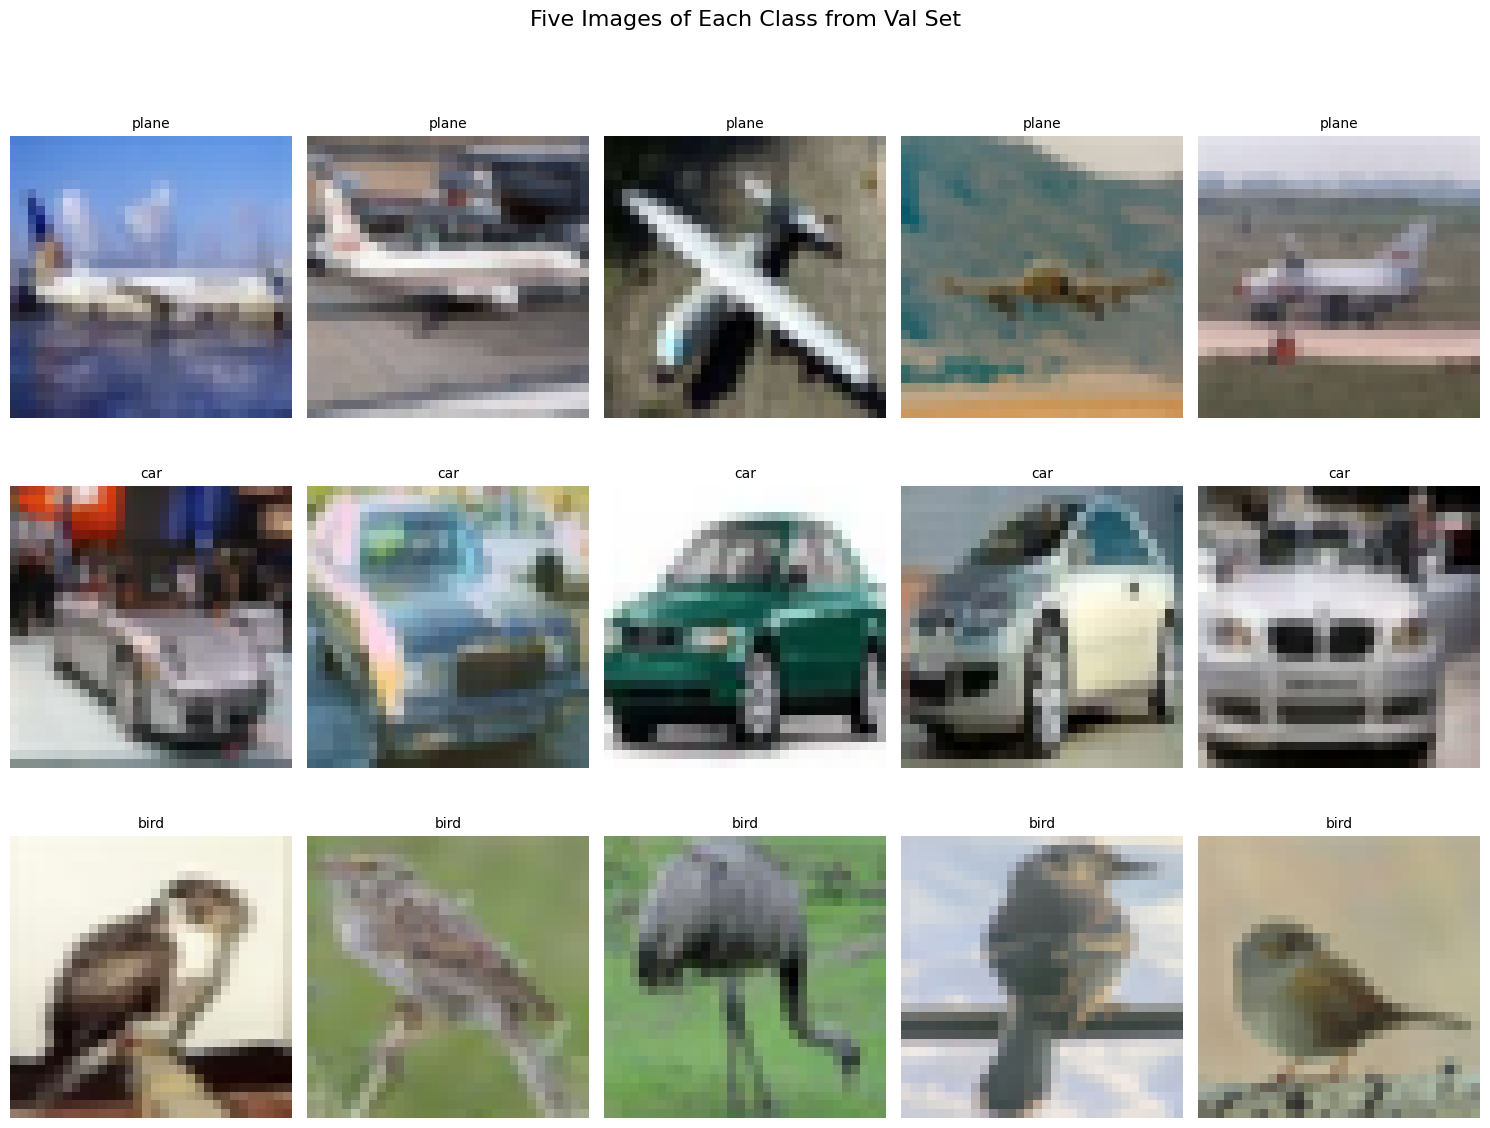

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
class_samples = {i: [] for i in range(len(classes))}
for it in val_loader:
    images, labels = it
    for i in range(len(labels)):
        label = labels[i].item()
        if len(class_samples[label]) < 5:
            class_samples[label].append(images[i])
    if all(len(class_samples[i]) >= 5 for i in range(len(classes))):
        break
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 12))
fig.suptitle('Five Images of Each Class from Val Set', fontsize=16)
for class_idx, class_name in enumerate(classes):
    for img_idx in range(5):
        ax = axes[class_idx, img_idx]
        img = class_samples[class_idx][img_idx]
        img = img / 2 + 0.5
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.axis('off')
        if img_idx == 0:
            ax.set_ylabel(class_name, rotation=0, labelpad=50, fontsize=12, ha='right')
        ax.set_title(class_name, fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Setting the architecture

In [ ]:

class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.fc1 = nn.Linear(512, 16)
        self.fc2 = nn.Linear(16, len(classes))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        # print(x.shape)
        # print(x)
        #print(len(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Training the CNN 

In [ ]:
device = torch.device( "cpu")
print(f"device: {device}")
model = CNN_Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
def compute_acc(loader, model):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for it in loader:
            inputs, labels = it
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            ki, pred = torch.max(outputs, 1)
            total += labels.size(0)
            for i in range(len(labels)):
                if pred[i] == labels[i]:
                    correct += 1
    acc = 100 * correct / total
    return acc
epochs = 15
train_losses = []
val_losses = []
train_accs,val_accs = [],[]

for epoch in range(epochs):
    model.train()
    rl = 0.0
    correct_train = 0
    total_train = 0
    start_time = time.time()
    for it in train_loader:
        inputs, labels = it
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        rl += loss.item()
        ki, pred = torch.max(outputs, 1)
        total_train += labels.size(0)
        for i in range(len(labels)):
            if pred[i] == labels[i]:
                correct_train += 1
    train_loss = rl / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    val_loss = 0.0
    correct_val = 0
    total_val = 0

    model.eval()
    with torch.no_grad():
        for it in val_loader:
            inputs, labels = it
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            ki, pred = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (pred == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"epoch: {epoch + 1}/{epochs}" )
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")
    print(f"Epoch Time: {epoch_time:.2f} s")
    print()
torch.save(model.state_dict(), 'cnn_model.pth')
print("model saved ")

Using device: cpu
Epoch [1/15], Train Loss: 0.5681, Train acc: 77.09%, Validation Loss: 0.4422, Validation acc: 82.97%, Time: 19.38 seconds
Epoch [2/15], Train Loss: 0.4093, Train acc: 84.25%, Validation Loss: 0.4040, Validation acc: 84.70%, Time: 17.70 seconds
Epoch [3/15], Train Loss: 0.3554, Train acc: 86.16%, Validation Loss: 0.4019, Validation acc: 84.37%, Time: 17.33 seconds
Epoch [4/15], Train Loss: 0.3187, Train acc: 87.88%, Validation Loss: 0.3552, Validation acc: 86.50%, Time: 17.06 seconds
Epoch [5/15], Train Loss: 0.2875, Train acc: 88.78%, Validation Loss: 0.3274, Validation acc: 87.33%, Time: 21.72 seconds
Epoch [6/15], Train Loss: 0.2647, Train acc: 89.80%, Validation Loss: 0.3168, Validation acc: 88.03%, Time: 25.63 seconds
Epoch [7/15], Train Loss: 0.2460, Train acc: 90.45%, Validation Loss: 0.3039, Validation acc: 89.13%, Time: 26.26 seconds
Epoch [8/15], Train Loss: 0.2284, Train acc: 91.07%, Validation Loss: 0.3233, Validation acc: 88.10%, Time: 25.58 seconds
Epoch 

# Plotting the train and val losses and accs

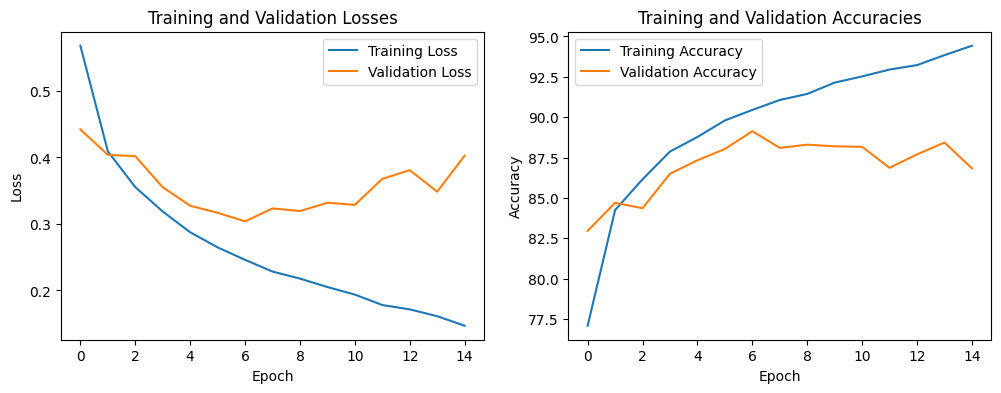

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracies')
plt.show()



# Loading the CNN 

In [4]:
net = CNN_Model()
PATH = './cnn_model.pth'
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

# Calculating the acc on test set 

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        ki, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        for i in range(len(labels)):
            if pred[i] == labels[i]:
                correct += 1

print(f'acc of the network on the 10000 test images: {100 * correct // total} %')

acc of the network on the 10000 test images: 87 %


# Calculating the classwise acc 

In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        ki, preds = torch.max(outputs, 1)
        for label, pred in zip(labels, preds):
            if label == pred:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, cc in correct_pred.items():
    acc = 100 * float(cc) / total_pred[classname]
    print(f'acc for class: {classname:5s} is {acc:.2f} %')


acc for class: plane is 82.60 %
acc for class: car   is 89.50 %
acc for class: bird  is 91.80 %


# Confusion matrix on Train , Test and Val set 

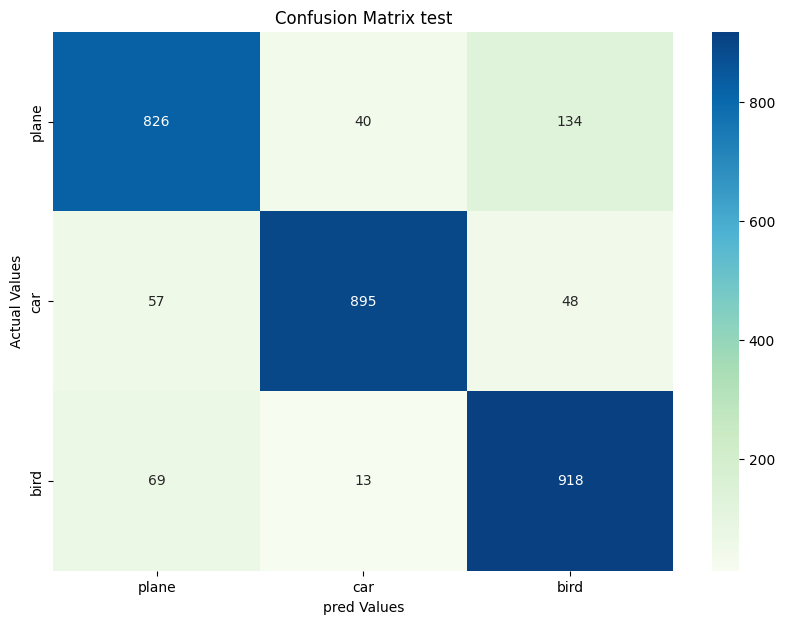

              precision    recall  f1-score   support

       plane       0.87      0.83      0.85      1000
         car       0.94      0.90      0.92      1000
        bird       0.83      0.92      0.87      1000

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



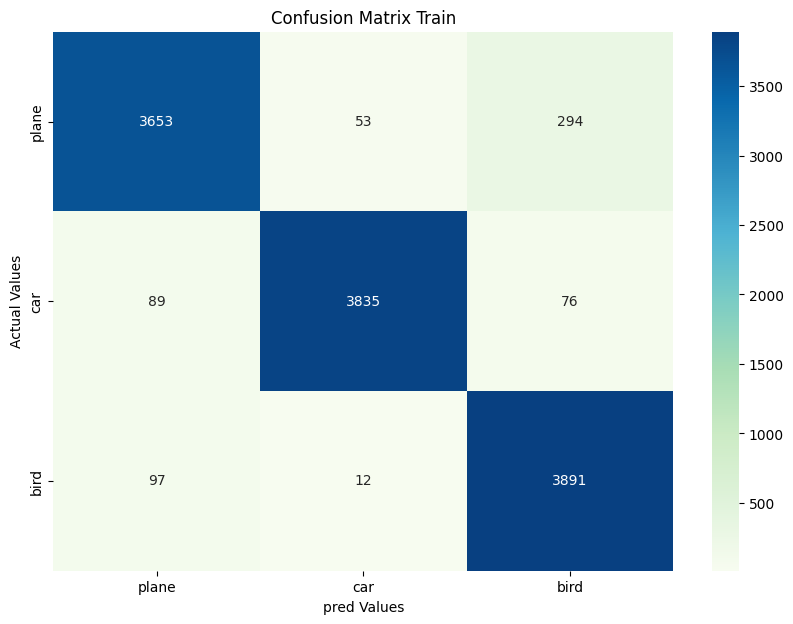

              precision    recall  f1-score   support

       plane       0.95      0.91      0.93      4000
         car       0.98      0.96      0.97      4000
        bird       0.91      0.97      0.94      4000

    accuracy                           0.95     12000
   macro avg       0.95      0.95      0.95     12000
weighted avg       0.95      0.95      0.95     12000



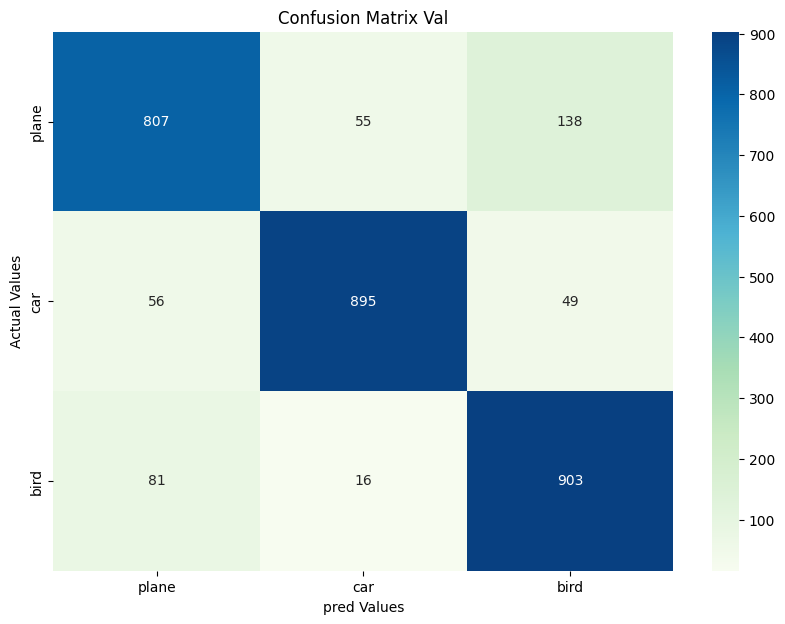

              precision    recall  f1-score   support

       plane       0.85      0.81      0.83      1000
         car       0.93      0.90      0.91      1000
        bird       0.83      0.90      0.86      1000

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



In [ ]:

p_list = torch.zeros(0, dtype=torch.long, device='cpu')
t_list = torch.zeros(0, dtype=torch.long, device='cpu')
class_labels = ('plane', 'car', 'bird')
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        ki, pred = torch.max(outputs, 1)
        p_list = torch.cat([p_list, pred.view(-1).cpu()])
        t_list = torch.cat([t_list, labels.view(-1).cpu()])

conf_mat = confusion_matrix(t_list.numpy(), p_list.numpy())

df_cm = pd.DataFrame(conf_mat, index=class_labels, columns=class_labels)
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='GnBu')
plt.title('Confusion Matrix test')
plt.ylabel('Actual Values')
plt.xlabel('pred Values')
plt.show()
print(classification_report(t_list.numpy(), p_list.numpy(), target_names=class_labels))

p_list = torch.zeros(0, dtype=torch.long, device='cpu')
t_list = torch.zeros(0, dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        ki, pred = torch.max(outputs, 1)
        p_list = torch.cat([p_list, pred.view(-1).cpu()])
        t_list = torch.cat([t_list, labels.view(-1).cpu()])

conf_mat = confusion_matrix(t_list.numpy(), p_list.numpy())
df_cm = pd.DataFrame(conf_mat, index=class_labels, columns=class_labels)
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, fmt='d' , cmap='GnBu')
plt.title('Confusion Matrix Train')
plt.ylabel('Actual Values')
plt.xlabel('pred Values')
plt.show()
print(classification_report(t_list.numpy(), p_list.numpy(), target_names=class_labels))

p_list = torch.zeros(0, dtype=torch.long, device='cpu')
t_list = torch.zeros(0, dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = net(images)
        ki, pred = torch.max(outputs, 1)
        p_list = torch.cat([p_list, pred.view(-1).cpu()])
        t_list = torch.cat([t_list, labels.view(-1).cpu()])

conf_mat = confusion_matrix(t_list.numpy(), p_list.numpy())
df_cm = pd.DataFrame(conf_mat, index=class_labels, columns=class_labels)
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='GnBu')
plt.title('Confusion Matrix Val')
plt.ylabel('Actual Values')
plt.xlabel('pred Values')
plt.show()
print(classification_report(t_list.numpy(), p_list.numpy(), target_names=class_labels))

# Setting up MLP architecture 

In [6]:
class MLP_Model(nn.Module):
    def __init__(self):
        super(MLP_Model, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 3, 64)
        self.fc2 = nn.Linear(64, len(classes))
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training the MLP 

In [ ]:
mlp_model = MLP_Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.0001)
num_epochs = 15
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    start_time = time.time()
    mlp_model.train()
    rl = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mlp_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        rl += loss.item()
        ki, pred = torch.max(outputs, 1)
        total_train += labels.size(0)
        for i in range(len(labels)):
            if pred[i] == labels[i]:
                correct_train += 1

    train_loss = rl / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    mlp_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mlp_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            ki, pred = torch.max(outputs, 1)
            total_val += labels.size(0)
            for i in range(len(labels)):
                if pred[i] == labels[i]:
                    correct_val += 1

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    end_time = time.time()
    epoch_time = end_time - start_time
    
    print(f"Epoch [{epoch+1}/{num_epochs}],"
            f"Train Loss: {train_loss:.4f}, Train acc: {train_acc:.2f}%, "
            f"Validation Loss: {val_loss:.4f}, Validation acc: {val_acc:.2f}%, "
            f"Time: {epoch_time:.2f} seconds")
torch.save(mlp_model.state_dict(), 'mlp_model.pth')



Epoch [1/15], Train Loss: 0.7137, Train acc: 71.39%, Validation Loss: 0.6461, Validation acc: 75.07%, Time: 18.94 seconds
Epoch [2/15], Train Loss: 0.6056, Train acc: 76.50%, Validation Loss: 0.6462, Validation acc: 74.77%, Time: 17.27 seconds
Epoch [3/15], Train Loss: 0.5494, Train acc: 78.78%, Validation Loss: 0.6678, Validation acc: 75.07%, Time: 16.05 seconds
Epoch [4/15], Train Loss: 0.5144, Train acc: 80.57%, Validation Loss: 0.6233, Validation acc: 76.03%, Time: 15.82 seconds
Epoch [5/15], Train Loss: 0.4826, Train acc: 81.68%, Validation Loss: 0.6298, Validation acc: 77.07%, Time: 17.96 seconds
Epoch [6/15], Train Loss: 0.4450, Train acc: 82.85%, Validation Loss: 0.6467, Validation acc: 76.67%, Time: 17.20 seconds
Epoch [7/15], Train Loss: 0.4224, Train acc: 84.46%, Validation Loss: 0.6667, Validation acc: 76.60%, Time: 17.31 seconds
Epoch [8/15], Train Loss: 0.4001, Train acc: 84.96%, Validation Loss: 0.7363, Validation acc: 76.70%, Time: 15.33 seconds
Epoch [9/15], Train Loss

# Plotting the loss and accs of MLP 

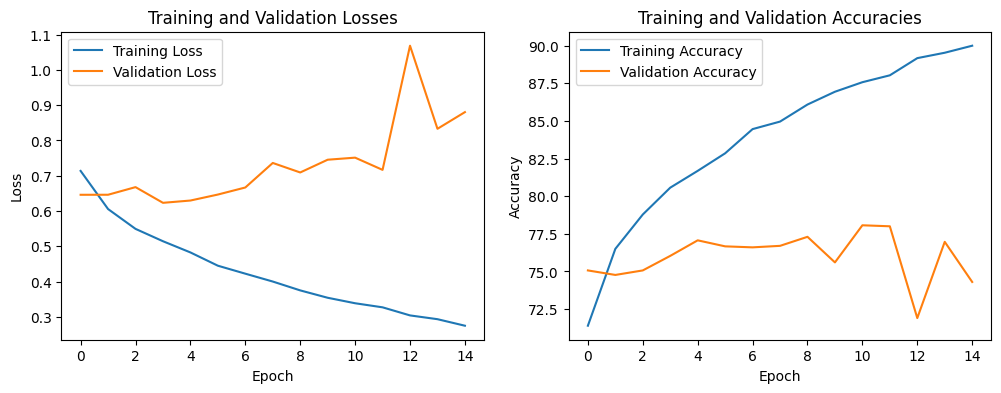

In [20]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracies')
plt.show()


# Loading the model 

In [7]:
mlp_model = MLP_Model()
mlp_model.load_state_dict(torch.load('mlp_model.pth'))

C:\Users\halog\AppData\Local\Temp\ipykernel_9984\3030132316.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load('mlp_model.pth'))


<All keys matched successfully>

# Test acc 

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = mlp_model(images)
        ki, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        for i in range(len(labels)):
            if pred[i] == labels[i]:
                correct += 1

print(f'acc of the network on the 3000 test images: {100 * correct // total} %')

acc of the network on the 3000 test images: 75 %


# Classwise acc

In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = mlp_model(images)
        ki, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    acc = 100 * float(correct_count) / total_pred[classname]
    print(f'acc for class: {classname:5s} is {acc:.1f} %')

acc for class: plane is 64.3 %
acc for class: car   is 84.1 %
acc for class: bird  is 77.4 %


# Confusion matrix

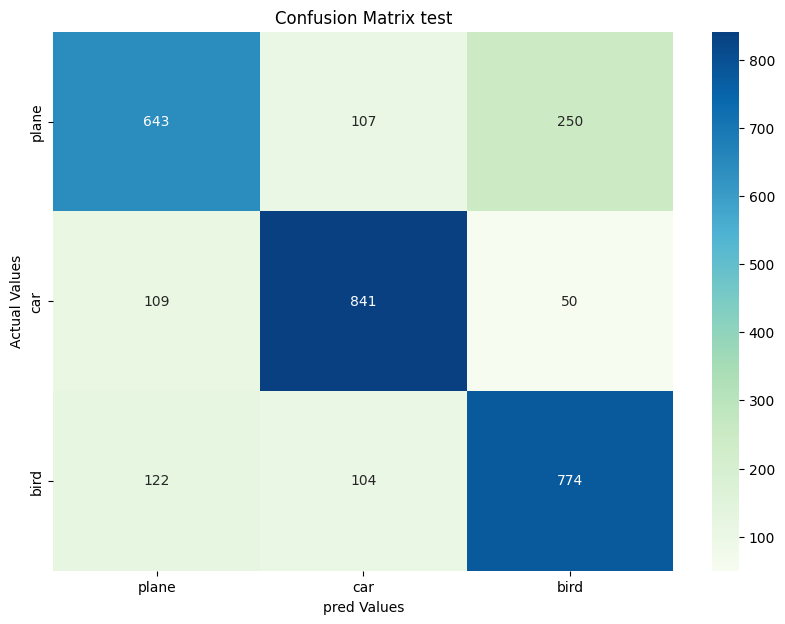

              precision    recall  f1-score   support

       plane       0.74      0.64      0.69      1000
         car       0.80      0.84      0.82      1000
        bird       0.72      0.77      0.75      1000

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000



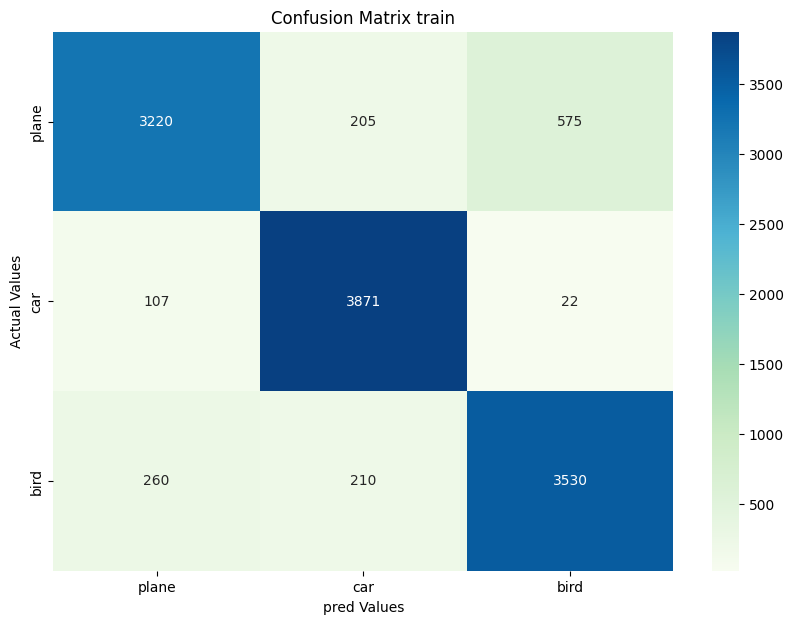

              precision    recall  f1-score   support

       plane       0.90      0.81      0.85      4000
         car       0.90      0.97      0.93      4000
        bird       0.86      0.88      0.87      4000

    accuracy                           0.89     12000
   macro avg       0.89      0.89      0.88     12000
weighted avg       0.89      0.89      0.88     12000



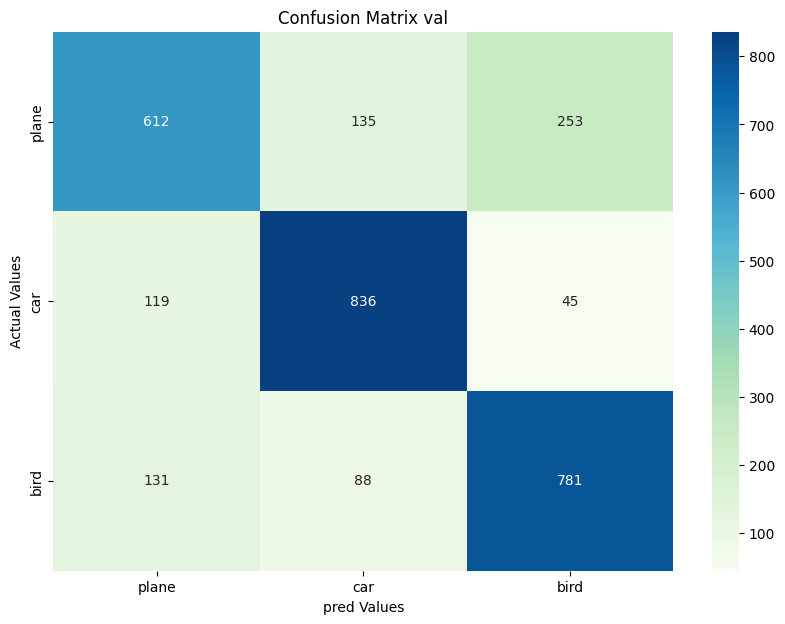

              precision    recall  f1-score   support

       plane       0.71      0.61      0.66      1000
         car       0.79      0.84      0.81      1000
        bird       0.72      0.78      0.75      1000

    accuracy                           0.74      3000
   macro avg       0.74      0.74      0.74      3000
weighted avg       0.74      0.74      0.74      3000



In [ ]:
class_labels = ('plane', 'car', 'bird')
p_list = torch.zeros(0, dtype=torch.long, device='cpu')
t_list = torch.zeros(0, dtype=torch.long, device='cpu')

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = mlp_model(images)
        ki, pred = torch.max(outputs, 1)
        p_list = torch.cat([p_list, pred.view(-1).cpu()])
        t_list = torch.cat([t_list, labels.view(-1).cpu()])
conf_mat = confusion_matrix(t_list.numpy(), p_list.numpy())
df_cm = pd.DataFrame(conf_mat, index=class_labels, columns=class_labels)
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, fmt='d',cmap='GnBu')  
plt.title('Confusion Matrix test')
plt.ylabel('Actual Values')
plt.xlabel('pred Values')
plt.show()
print(classification_report(t_list.numpy(), p_list.numpy(), target_names=class_labels))

p_list = torch.zeros(0, dtype=torch.long, device='cpu')
t_list = torch.zeros(0, dtype=torch.long, device='cpu')

with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = mlp_model(images)
        ki, pred = torch.max(outputs, 1)
        p_list = torch.cat([p_list, pred.view(-1).cpu()])
        t_list = torch.cat([t_list, labels.view(-1).cpu()])
conf_mat = confusion_matrix(t_list.numpy(), p_list.numpy())
df_cm = pd.DataFrame(conf_mat, index=class_labels, columns=class_labels)
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='GnBu')  
plt.title('Confusion Matrix train')
plt.ylabel('Actual Values')
plt.xlabel('pred Values')
plt.show()
print(classification_report(t_list.numpy(), p_list.numpy(), target_names=class_labels))


p_list = torch.zeros(0, dtype=torch.long, device='cpu')
t_list = torch.zeros(0, dtype=torch.long, device='cpu')

with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = mlp_model(images)
        ki, pred = torch.max(outputs, 1)
        p_list = torch.cat([p_list, pred.view(-1).cpu()])
        t_list = torch.cat([t_list, labels.view(-1).cpu()])
conf_mat = confusion_matrix(t_list.numpy(), p_list.numpy())
df_cm = pd.DataFrame(conf_mat, index=class_labels, columns=class_labels)
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap ='GnBu')  
plt.title('Confusion Matrix val')
plt.ylabel('Actual Values')
plt.xlabel('pred Values')
plt.show()
print(classification_report(t_list.numpy(), p_list.numpy(), target_names=class_labels))